In [1]:
pip install scikit-learn==1.1.3


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
import csv


In [3]:
data = pd.read_csv('../sale_price_prediction_data.csv')


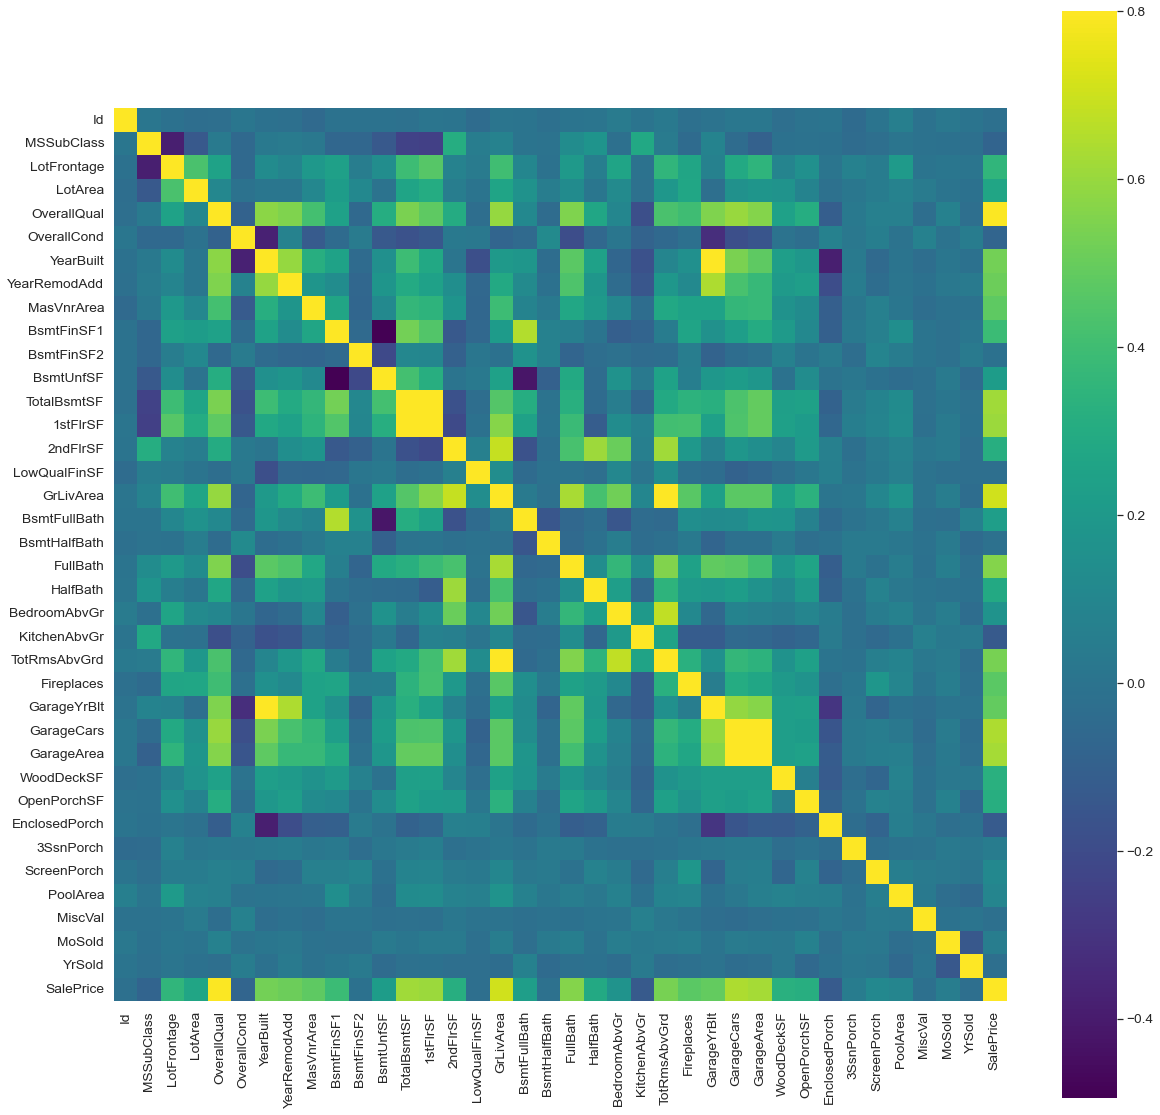

In [24]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.25)
sns.heatmap(corrmat, annot = False, vmax=0.8, square=True, annot_kws={'size': 10},cmap = 'viridis');




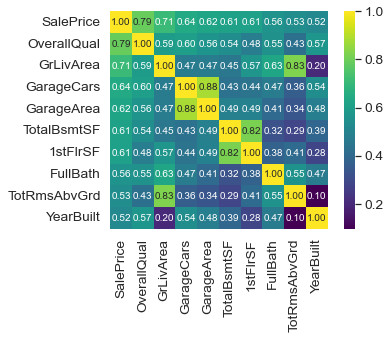

In [5]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,cmap = 'viridis')
plt.show()

In [7]:
# #Identify features with strong correlation

# correlation_threshold = 0.6

# # Get the indices of strongly correlated pairs
# strongly_correlated_pairs = np.where(np.abs(corr) >= correlation_threshold)

# # Extract strongly correlated values and pairs
# strongly_correlated_values = [(corr.iloc[i, j], corr.index[i], corr.columns[j]) 
#                               for i, j in zip(*strongly_correlated_pairs) if i != j]

# # Display strongly correlated values and pairs
# print("Strongly Correlated Values and Pairs:")
# for corr_value, feature1, feature2 in strongly_correlated_values:
#     print(f"Correlation: {corr_value:.2f} between '{feature1}' and '{feature2}'")

In [18]:
# Spliting target variable and independent variables
X = data.drop(['SalePrice'], axis = 1)
y = data['SalePrice']

# Splitting to training and testing data
print(data.describe())
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 4)

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

In [15]:
print('------------Linear Regression-----------------')
# Import library for Linear Regression
from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets
lm.fit(X_train, y_train)

# Value of y intercept



------------Linear Regression-----------------


ValueError: could not convert string to float: 'RM'

In [ ]:
#Converting the coefficient values to a dataframe
coeffcients = pd.DataFrame([X_train.columns,lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})
print(coeffcients)

# Model prediction on train data
y_pred = lm.predict(X_train)
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

# Predicting Test data with the model
y_test_pred = lm.predict(X_test)
# Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
mae_linreg = metrics.mean_absolute_error(y_test, y_test_pred)
rmse_linreg = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('R^2:', acc_linreg)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',mae_linreg)
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',rmse_linreg)

In [ ]:
# Visualizing the differences between actual prices and predicted values
plt.clf()
plt.scatter(y_test, y_test_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices", labelpad=1.5)
plt.title("Prices vs Predicted prices")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='r', lw=3, scalex=False, scaley=False)
plt.show()

# Checking residuals
plt.clf()
plt.scatter(y_test_pred,y_test-y_test_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals", labelpad=1.5)
plt.show()

# Checking Normality of errors
plt.clf()
sns.distplot(y_test-y_test_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [ ]:
print('------------XGBoost Regressor-----------------')
# Import XGBoost Regressor
from xgboost import XGBRegressor

#Create a XGBoost Regressor
reg = XGBRegressor()

# Train the model using the training sets
reg.fit(X_train, y_train)

# Model prediction on train data
y_pred = reg.predict(X_train)

# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

#Predicting Test data with the model
y_test_pred = reg.predict(X_test)

# Model Evaluation
acc_xgb = metrics.r2_score(y_test, y_test_pred)
mae_xgb = metrics.mean_absolute_error(y_test, y_test_pred)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('R^2:', acc_xgb)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',mae_xgb)
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',rmse_xgb)



In [ ]:
# Visualizing the differences between actual prices and predicted values
plt.clf()
plt.scatter(y_test, y_test_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices", labelpad=1.5)
plt.title("Prices vs Predicted prices")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='r', lw=3, scalex=False, scaley=False)

plt.show()


In [ ]:

# Checking residuals
plt.scatter(y_test_pred,y_test-y_test_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals", labelpad=1.5)
plt.show()


In [ ]:

# Checking Normality of errors
plt.clf()
sns.distplot(y_test-y_test_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [ ]:
from xgboost import plot_importance
plt.clf()
fig,ax = plt.subplots(figsize=(10,10))
plot_importance(reg,height=0.5,max_num_features=64,ax=ax)
plt.show()